<a href="https://colab.research.google.com/github/byambaa1982/data_analysis/blob/master/modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sb

In [0]:
# !pip install --upgrade tensorflow

In [0]:
df=pd.read_csv('/content/for_model (1).csv')

# Categorical columns
In this dataset, Client, Sub code, SubGroupID and Tel 1 are represented as a string (e.g. 'DIFF-LEGAL', 'normal', or 'DIFF-UTD'). We cannot feed strings directly to a model. Instead, we must first map them to numeric values. The categorical vocabulary columns provide a way to represent strings as a one-hot vector (much like you have seen above with age buckets). The vocabulary can be passed as a list using LabelEncoder. 

In [37]:
df.age=df.age.map(lambda x:abs(x) if x<0 else x)
lb_make = LabelEncoder()
df["code_client"] = lb_make.fit_transform(df["Client"])
df["Client"]=df["Client"].map(lambda x:str(x) if type(x)!=str else x)
df["code_subcode"] = lb_make.fit_transform(df["Sub Code"])
df["SubGroupID"]=df["SubGroupID"].map(lambda x:str(x) if type(x)!=str else x)
df["code_subgroupid"] = lb_make.fit_transform(df["SubGroupID"])
df["code_tel"] = lb_make.fit_transform(df["Tel 1"])
df["instr_bal"]=df["Instr Bal"]
df=df[['Reason', 'Paid','age', 'code_client', 'code_subcode', 'code_tel',
       'code_subgroupid','instr_bal']]
df.head(11)

,Reason,Paid,age,code_client,code_subcode,code_tel,code_subgroupid,instr_bal
0,0,0.00,25.257192,1,2,7,12,1034.40
1,0,0.00,30.273038,1,2,5,40,478.83
2,0,0.00,30.021150,1,2,4,44,780.86
3,0,60.00,36.583913,1,2,4,50,524.14
4,0,0.00,24.509744,1,2,6,55,473.81
5,1,552.98,26.281169,4,5,4,73,552.98
6,1,194.72,32.468839,4,5,4,23,194.72
7,1,876.51,57.920423,4,5,5,34,876.51
8,1,824.16,41.369775,4,5,4,22,824.17
9,1,112.25,27.340739,4,5,4,68,112.25


# Split the dataframe into train, validation, and test
The dataset we downloaded was a single CSV file. We will split this into train, validation, and test sets.

In [38]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

17752 train examples
4439 validation examples
5548 test examples


# Create an input pipeline using tf.data

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(df, shuffle=True, batch_size=32):
  df = df.copy()
  labels = df.pop('Reason')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(df))
  ds = ds.batch(batch_size)
  return ds

In [0]:
batch_size = 5 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [41]:
for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))
  print('A batch of ages:', feature_batch['age'])
  print('A batch of targets:', label_batch )

Every feature: ['Paid', 'age', 'code_client', 'code_subcode', 'code_tel', 'code_subgroupid', 'instr_bal']
A batch of ages: tf.Tensor([26.28390727 46.82368563 30.66455848 22.37143815 38.0596453 ], shape=(5,), dtype=float64)
A batch of targets: tf.Tensor([0 0 0 0 0], shape=(5,), dtype=int32)


In [0]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

In [0]:
# A utility method to create a feature column
# and to transform a batch of data
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [0]:
feature_columns = []

# numeric cols
for header in ['Paid', 'age', 'code_client', 'code_subcode',
       'code_tel', 'code_subgroupid','instr_bal']:
  feature_columns.append(feature_column.numeric_column(header))

# Create a feature layer
Now that we have defined our feature columns, we will use a DenseFeatures layer to input them to our Keras model.

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

We create a new input pipeline with a larger batch size.

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

# Create, compile, and train the model

In [50]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=5)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/5
555/555 [==============================] - 6s 10ms/step - loss: 1.8316 - accuracy: 0.9100 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
555/555 [==============================] - 2s 4ms/step - loss: 0.6742 - accuracy: 0.9215 - val_loss: 0.2413 - val_accuracy: 0.9349
Epoch 3/5
555/555 [==============================] - 2s 4ms/step - loss: 0.6839 - accuracy: 0.9205 - val_loss: 0.9453 - val_accuracy: 0.9344
Epoch 4/5
555/555 [==============================] - 2s 3ms/step - loss: 0.5

In [51]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

174/174 [==============================] - 0s 2ms/step - loss: 0.4853 - accuracy: 0.9265
Accuracy 0.92645997


In [62]:
history=model.fit(train_ds,
          validation_data=val_ds,
          epochs=15)
history_dict = history.history
history_dict.keys()

Epoch 1/15
555/555 [==============================] - 4s 8ms/step - loss: 0.2139 - accuracy: 0.9296 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
555/555 [==============================] - 2s 3ms/step - loss: 0.1665 - accuracy: 0.9312 - val_loss: 0.1585 - val_accuracy: 0.9320
Epoch 3/15
555/555 [==============================] - 2s 4ms/step - loss: 0.1702 - accuracy: 0.9305 - val_loss: 0.1482 - val_accuracy: 0.9390
Epoch 4/15
555/555 [==============================] - 2s 4ms/step - loss: 0.1618 - accuracy: 0.9329 - val_loss: 0.1689 - val_accuracy: 0.9322
Epoch 5/15
555/555 [==============================] - 2s 4ms/step - loss: 0.1620 - accuracy: 0.9332 - val_loss: 0.1610 - val_accuracy: 0.9396
Epoch 6/15
555/555 [==============================] - 2s 4ms/step - loss: 0.1563 - accuracy: 0.9322 - val_loss: 0.1474 - val_accuracy: 0.9392
Epoch 7/15
555/555 [==============================] - 2s 4ms/step - loss: 0.1520 - accuracy: 0.9348 - val_loss: 0.1472 - val_accuracy: 0.937

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [66]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

174/174 [==============================] - 0s 2ms/step - loss: 0.1410 - accuracy: 0.9382
Loss:  0.1409735739948335
Accuracy:  0.9381759


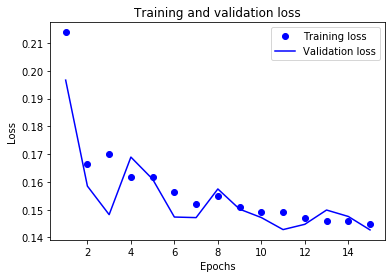

In [63]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

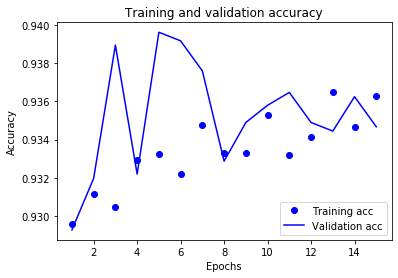

In [64]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Key point: You are seeing the best results. Accuracy is 94 percent.

In [69]:
predictions = model.predict(test_ds)

# Show just 20 results
for prediction, paid in zip(predictions[:20], list(test_ds)[0][1][:10]):
  print("Predicted Reason by Percentage: {:.2%}".format(prediction[0]),
        " | Actual outcome: ",
        ("PAID" if bool(paid) else "NOT PAID"))

Predicted Reason by Percentage: 1.19%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 0.24%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 0.56%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 34.50%  | Actual outcome:  PAID
Predicted Reason by Percentage: 1.38%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 1.89%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 40.65%  | Actual outcome:  PAID
Predicted Reason by Percentage: 0.15%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 2.31%  | Actual outcome:  NOT PAID
Predicted Reason by Percentage: 0.05%  | Actual outcome:  NOT PAID


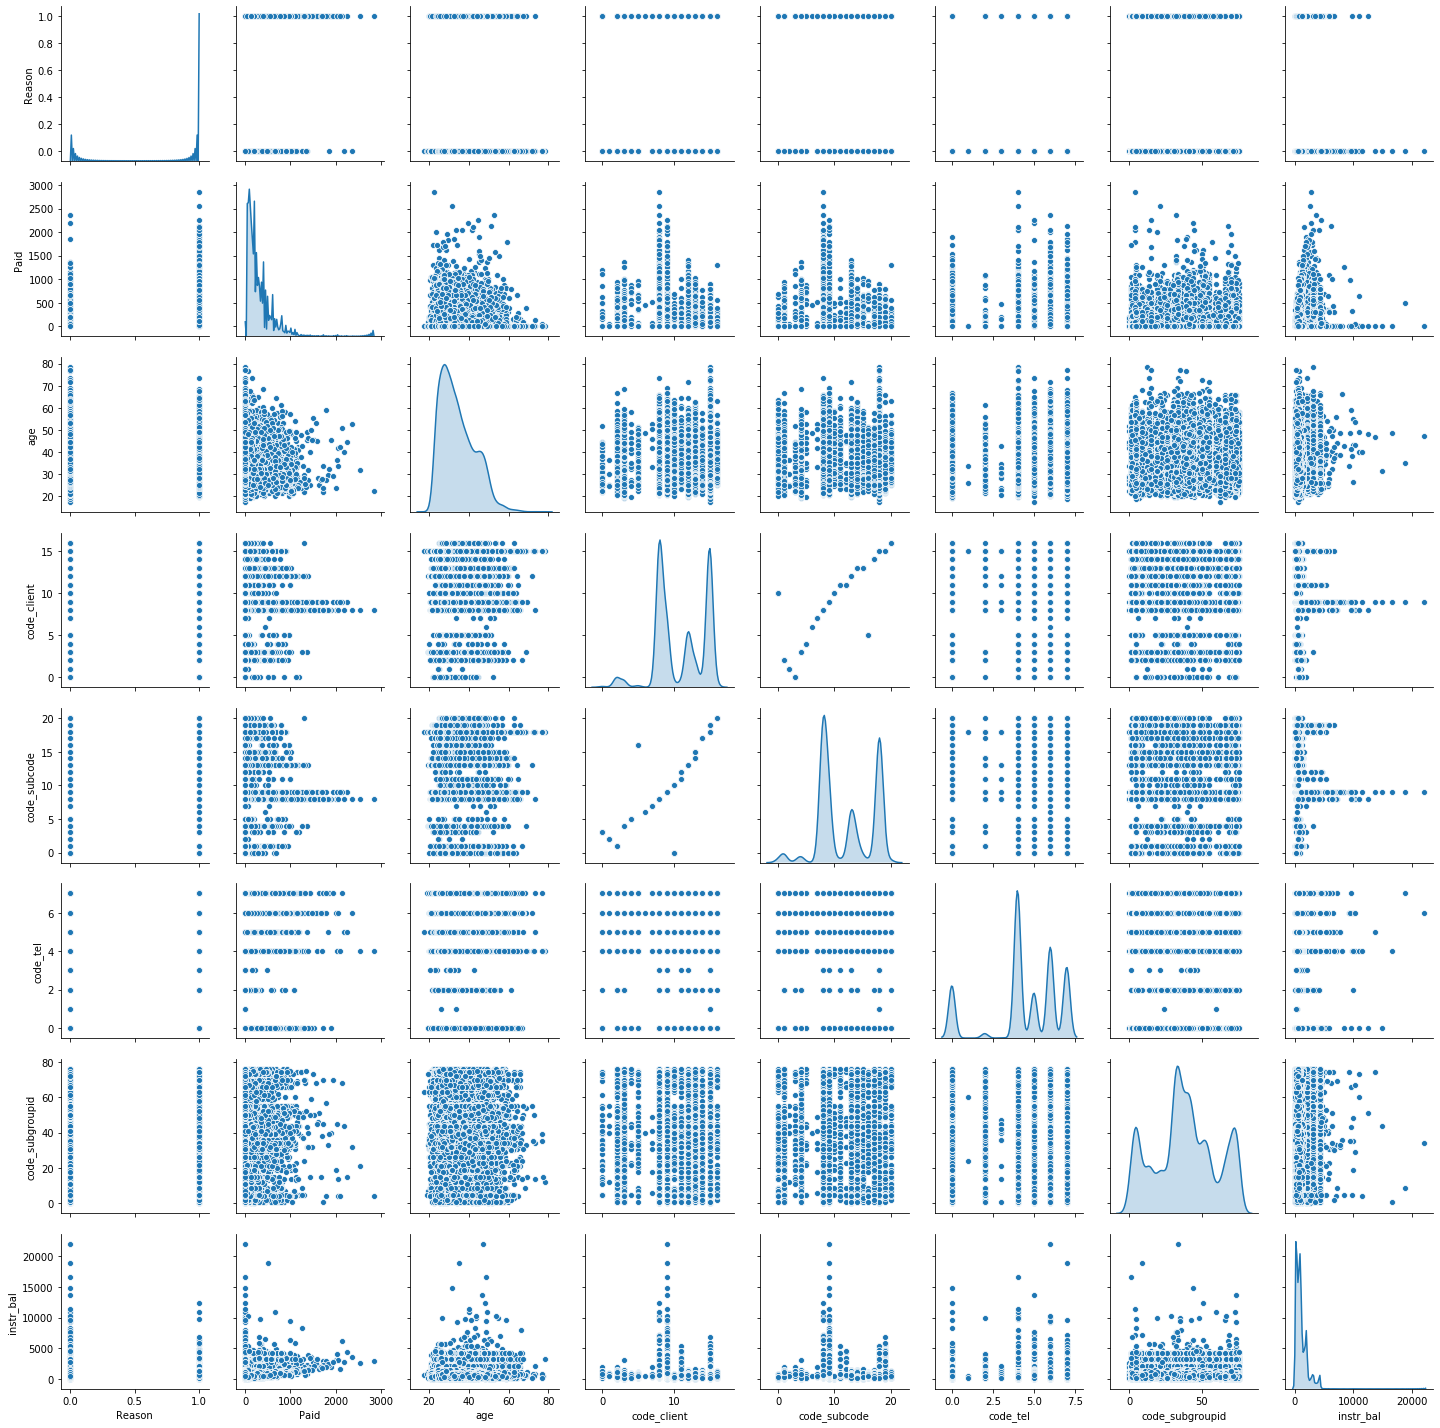

In [56]:
sns.pairplot(df[['Reason', 'Paid', 'age', 'code_client', 'code_subcode', 'code_tel',
       'code_subgroupid', 'instr_bal']], diag_kind="kde")

In [0]:
# CATEGORIES = {
#     'Client': [i for i in df['Client'].unique()],
#     'Sub Code' : [i for i in df['Sub Code'].unique()],
#     'SubGroupID' : [i for i in df['SubGroupID'].unique()],
#    'Tel 1' : [i for i in df['Tel 1'].unique()],
# }